Changelog:  (Last Updated 2023-03-24)


* Added re-initializing parameters in 1.e



# Probabilistic ML: Assignment 3
- **Deadline**: 2023-03-27 (March 27th 2023)
- **Submission**: You need to submit your solutions through MarkUs, including all your derivations, plots, and your code. You can produce the files however you like (e.g. $\LaTeX$, Microsoft Word, etc), as long as it is readable. Points will be deducted if we have a hard time reading your solutions or understanding the structure of your code.
- **Collaboration policy**: After attempting the problems on an individual basis, you may discuss and work together on the assignment with up to two classmates. However, **you must write your own code and write up your own solutions individually and explicitly name any collaborators** at the top of the homework.

# 1. [54pts] Stochastic Variational Inference in the TrueSkill Model

## Background

We'll continue working with [TrueSkill](http://papers.nips.cc/paper/3079-trueskilltm-a-bayesian-skill-rating-system.pdf) model, a player ranking system for competitive games originally developed for Halo 2. Recall the model:


## Model definition

We assume that each player has a true, but unknown skill $z_i \in \mathbb{R}$.
We use $N$ to denote the number of players.

### The prior:
The prior over each player's skill is a standard normal distribution, and all player's skills are *a priori* independent.

### The likelihood:
For each observed game, the probability that player $i$ beats player $j$, given the player's skills $z_A$ and $z_B$, is:
$$p(A \,\, \text{beat} \,\, B | z_A, z_B) = \sigma(z_i - z_j)$$
where
$$\sigma(y) = \frac{1}{1 + \exp(-y)}$$
We chose this function simply because it's close to zero or one when the player's skills are very different, and equals one-half when the player skills are the same.  This likelihood function is the only thing that gives meaning to the latent skill variables $z_1 \dots z_N$.

There can be more than one game played between a pair of players. The outcome of each game is independent given the players' skills.
We use $M$ to denote the number of games.


In [1]:
!pip install wget
import os
import os.path

import matplotlib.pyplot as plt
import wget

import pandas as pd


import numpy as np
from scipy.stats import norm
import scipy.io
import scipy.stats
import torch 
import random
from torch import nn
from torch.distributions.normal import Normal

from functools import partial
from tqdm import trange, tqdm_notebook

import matplotlib.pyplot as plt

# Helper function
def diag_gaussian_log_density(x, mu, std):
    # axis=-1 means sum over the last dimension.
    m = Normal(mu, std)
    return torch.sum(m.log_prob(x), axis=-1)

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Preparing metadata (setup.py) ... done
  Created wheel for wget: filename=wget-3.2-py3-none-any.whl size=9676 sha256=9968f797909a64ab3c5bbc737dbae68d5bdbebfa32d5bdbb66a0767983bf5fc3
  Stored in directory: /root/.cache/pip/wheels/04/5f/3e/46cc37c5d698415694d83f607f833f83f0149e49b3af9d0f38
Successfully built wget


## Implementing the TrueSkill Model



This part was mostly done in Assignment 2. We will recall some useful functions.

**a)** The function $\texttt{log_joint_prior}$ computes the log of the prior, jointly evaluated over all player's skills.

In [2]:
def log_joint_prior(zs_array):
    return diag_gaussian_log_density(zs_array, torch.tensor([0.0]), torch.tensor([1.0]))

**b)** The function `logp_a_beats_b` that, given a pair of skills $z_a$ and $z_b$, evaluates the log-likelihood that player with skill $z_a$ beat player with skill $z_b$ under the model detailed above.

To ensure numerical stability, we use the function `np.log1p` that computes $\log(1 + x)$ in a numerically stable way.  Or even better, use `np.logaddexp`.

In [3]:
def logp_a_beats_b(z_a, z_b):
    return -torch.logaddexp(torch.tensor([0.0]), z_b - z_a)

def log_prior_over_2_players(z1, z2):
    m = Normal(torch.tensor([0.0]), torch.tensor([[1.0]]))
    return m.log_prob(z1) + m.log_prob(z2)

def prior_over_2_players(z1, z2):
    return torch.exp(log_prior_over_2_players(z1, z2))

def log_posterior_A_beat_B(z1, z2):
    return log_prior_over_2_players(z1, z2) + logp_a_beats_b(z1, z2)

def posterior_A_beat_B(z1, z2):
    return torch.exp(log_posterior_A_beat_B(z1, z2))

def log_posterior_A_beat_B_10_times(z1, z2):
    return log_prior_over_2_players(z1, z2) + 10.0 * logp_a_beats_b(z1, z2)

def posterior_A_beat_B_10_times(z1, z2):
    return torch.exp(log_posterior_A_beat_B_10_times(z1, z2))

def log_posterior_beat_each_other_10_times(z1, z2):
    return log_prior_over_2_players(z1, z2) \
        + 10.* logp_a_beats_b(z1, z2) \
        + 10.* logp_a_beats_b(z2, z1)

def posterior_beat_each_other_10_times(z1, z2):
    return torch.exp(log_posterior_beat_each_other_10_times(z1, z2))

The following functions will be used for plotting.  Note that `plot_2d_fun` can now take an optional second function, so you can compare two functions.

In [4]:
# Plotting helper functions for free
def plot_isocontours(ax, func, xlimits=[-4, 4], ylimits=[-4, 4], steps=101, cmap="summer"):
    x = torch.linspace(*xlimits, steps=steps)
    y = torch.linspace(*ylimits, steps=steps)
    X, Y = torch.meshgrid(x, y)
    Z = func(X, Y)
    plt.contour(X, Y, Z, cmap=cmap)
    ax.set_yticks([])
    ax.set_xticks([])

def plot_2d_fun(f, x_axis_label="", y_axis_label="", f2=None, scatter_pts=None):
    # This is the function your code should call.
    # f() should take two arguments.
    fig = plt.figure(figsize=(8,8), facecolor='white')
    ax = fig.add_subplot(111, frameon=False)
    ax.set_xlabel(x_axis_label)
    ax.set_ylabel(y_axis_label)
    plot_isocontours(ax, f)
    if f2 is not None:
      plot_isocontours(ax, f2, cmap='winter')
    
    if scatter_pts is not None:
      plt.scatter(scatter_pts[:,0], scatter_pts[:, 1])
    plt.plot([4, -4], [4, -4], 'b--')   # Line of equal skill
    plt.show(block=True)
    plt.draw()

## **1.1 [20pts]** Stochastic Variational Inference on Two Players and Toy Data

One nice thing about a Bayesian approach is that it separates the model specification from the approximate inference strategy.
The original Trueskill paper from 2007 used message passing.

In this question we will  approximate posterior distributions with gradient-based stochastic variational inference.

The parameters are $\phi = (\mu,\log(\sigma))$. Notice that instead of $\sigma$ (which is constrained to be positive), we work with $\log(\sigma)$, removing the constraint. This way, we can do unconstrained gradient-based optimization.



**a) [9pts]** Implement the missing lines in the below code, to complete the evidence lower bound function and the reparameterized sampler for the approximate posterior.

Hint 1: You must use the reparametrization trick in your sampler if you want your gradients to be unbiased.

Hint 2: If you're worried you got these wrong, you can check that the sampler matches the log pdf by plotting a histogram of samples against a plot of the pdf.

In [5]:
def diag_gaussian_samples(mean, log_std, num_samples):
    # mean and log_std are (D) dimensional vectors
    # Return a (num_samples, D) matrix, where each sample is
    # from a diagonal multivariate Gaussian.

    # TODO.  You might want to use torch.randn(). Remember
    # you must use the reparameterization trick.  Also remember that
    # we are parameterizing the _log_ of the standard deviation.

    #Calculate q_phi
    D = np.shape(mean)[0]

    samples = torch.zeros(num_samples,D)
    for i in range(num_samples):
        epsilon = torch.randn(D)
        std = torch.exp(log_std)
        z = mean + torch.mul(epsilon,std)
        samples[i,:] = z
    
    return samples


def diag_gaussian_logpdf(x, mean, log_std):
    # Evaluate the density of a batch of points on a 
    # diagonal multivariate Gaussian. x is a (num_samples, D) matrix.
    # Return a tensor of shape (num_samples)
    
    return diag_gaussian_log_density(x,mean,torch.exp(log_std))

def batch_elbo(logprob, mean, log_std, num_samples):
    # TODO: Use simple Monte Carlo to estimate ELBO
    # on a batch of size num_samples
    x = diag_gaussian_samples(mean, log_std, num_samples)
    log_q_phi_z = diag_gaussian_logpdf(x,mean,log_std)
    L_phi = (1/num_samples)*torch.sum((logprob - log_q_phi_z))
    return L_phi
    


**b) [4pts]** Write a loss function called $\texttt{objective}$  that takes variational distribution parameters, and returns an unbiased estimate of the negative elbo using $\texttt{num_samples_per_iter}$ samples, to approximate the joint posterior over skills conditioned on observing player A winning 10 games.

Note: We want a _negative_ ELBO estimate, because the convention in optimization is to minimize functions, and we want to maximize the ELBO.

In [6]:
# Hyperparameters
num_players = 2
n_iters = 800
stepsize = 0.0001
num_samples_per_iter = 50

def log_posterior_A_beat_B_10_times_1_arg(z1z2):
  return log_posterior_A_beat_B_10_times(z1z2[:,0], z1z2[:,1]).flatten()

def objective(params):  # The loss function to be minimized.
  # TODO.  Hint:  This can be done in one line.

  x = diag_gaussian_samples(params[0], params[1], num_samples_per_iter)
  log_q_phi_z = diag_gaussian_logpdf(x,params[0], params[1])
  L_phi = (1/num_samples_per_iter)*torch.sum((log_posterior_A_beat_B_10_times_1_arg(x) - log_q_phi_z))

  return -L_phi

**c) [1pts]** Initialize a set of variational parameters and optimize them to approximate the joint where we observe player A winning 10 games. Report the final loss. Also plot the optimized variational approximation contours and the target distribution on the same axes.

Hint:  Almost initialization should be fine.  How many variational parameters do you need?

Optimizing variational parameters...


  1%|▏         | 10/800 [00:00<00:19, 40.41it/s]

Iteration 0 lower bound 8.544623374938965


  7%|▋         | 53/800 [00:00<00:06, 115.62it/s]

Iteration 25 lower bound 7.286600112915039
Iteration 50 lower bound 6.607093811035156


 10%|█         | 84/800 [00:00<00:06, 118.97it/s]

Iteration 75 lower bound 6.354072093963623


 16%|█▌        | 124/800 [00:01<00:06, 112.66it/s]

Iteration 100 lower bound 5.191931247711182
Iteration 125 lower bound 4.78957986831665


 20%|██        | 164/800 [00:01<00:05, 122.96it/s]

Iteration 150 lower bound 4.971106052398682
Iteration 175 lower bound 4.870728492736816


 27%|██▋       | 218/800 [00:02<00:05, 112.89it/s]

Iteration 200 lower bound 4.378220558166504
Iteration 225 lower bound 4.225251197814941


 34%|███▍      | 274/800 [00:02<00:04, 129.91it/s]

Iteration 250 lower bound 3.0810153484344482
Iteration 275 lower bound 3.310837745666504


 39%|███▉      | 314/800 [00:02<00:04, 110.49it/s]

Iteration 300 lower bound 3.1164135932922363


 41%|████      | 326/800 [00:03<00:05, 83.09it/s] 

Iteration 325 lower bound 3.2114171981811523


 45%|████▍     | 359/800 [00:03<00:05, 79.43it/s]

Iteration 350 lower bound 3.0582027435302734


 48%|████▊     | 384/800 [00:04<00:08, 48.13it/s]

Iteration 375 lower bound 2.9987025260925293


 52%|█████▎    | 420/800 [00:04<00:04, 80.04it/s]

Iteration 400 lower bound 3.2285139560699463


 55%|█████▌    | 440/800 [00:04<00:04, 81.45it/s]

Iteration 425 lower bound 3.197561502456665


 57%|█████▋    | 458/800 [00:05<00:06, 55.04it/s]

Iteration 450 lower bound 3.0135066509246826


 62%|██████▎   | 500/800 [00:05<00:03, 90.11it/s]

Iteration 475 lower bound 2.9716124534606934
Iteration 500 lower bound 3.223701000213623


 67%|██████▋   | 538/800 [00:06<00:03, 83.82it/s]

Iteration 525 lower bound 2.930537700653076


 69%|██████▊   | 549/800 [00:06<00:03, 82.14it/s]

Iteration 550 lower bound 2.9344186782836914


 75%|███████▍  | 597/800 [00:07<00:02, 69.29it/s]

Iteration 575 lower bound 2.9381489753723145


 77%|███████▋  | 615/800 [00:07<00:02, 70.70it/s]

Iteration 600 lower bound 2.9290122985839844


 80%|███████▉  | 636/800 [00:07<00:02, 69.85it/s]

Iteration 625 lower bound 2.98435378074646


 81%|████████▏ | 651/800 [00:08<00:02, 55.42it/s]

Iteration 650 lower bound 2.9606313705444336


 86%|████████▋ | 692/800 [00:09<00:02, 47.94it/s]

Iteration 675 lower bound 2.895428419113159


 90%|█████████ | 723/800 [00:10<00:01, 75.91it/s]

Iteration 700 lower bound 2.9545516967773438


 94%|█████████▍| 751/800 [00:10<00:00, 103.76it/s]

Iteration 725 lower bound 2.9982476234436035
Iteration 750 lower bound 2.9589381217956543


 99%|█████████▉| 792/800 [00:10<00:00, 118.46it/s]

Iteration 775 lower bound 2.9717183113098145


100%|██████████| 800/800 [00:10<00:00, 74.95it/s] 
/usr/local/lib/python3.9/dist-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3190.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


Final Iteration 799 lower bound 2.874028205871582


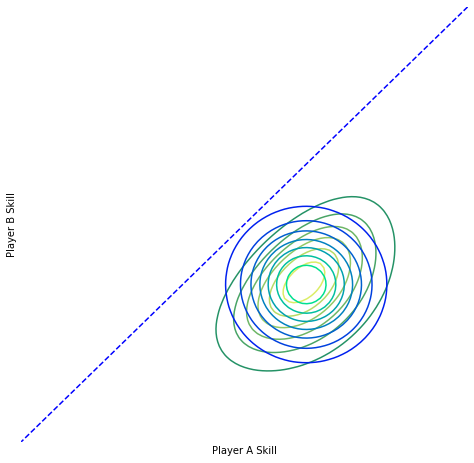

<Figure size 432x288 with 0 Axes>

In [7]:
def callback(params, t):
  if t % 25 == 0:
    print("Iteration {} lower bound {}".format(t, objective(params)))

# Set up optimizer.
D = 2

#Initialize mean 0, std = 10
init_log_std = torch.tensor([0.,0.],requires_grad=True) # TODO.
init_mean = torch.tensor([0.,0.],requires_grad=True) # TODO.

params = (init_mean, init_log_std)
optimizer = torch.optim.SGD(params, lr=stepsize, momentum=0.9)

def update():
    optimizer.zero_grad()
    loss = objective(params)
    loss.backward()
    optimizer.step()

# Main loop.
print("Optimizing variational parameters...")
for t in trange(0, n_iters):
    update()
    callback(params, t)

print("Final Iteration {} lower bound {}".format(t, objective(params)))

def approx_posterior_2d(z1, z2):
    # The approximate posterior
    mean, logstd = params[0].detach(), params[1].detach()
    return torch.exp(diag_gaussian_logpdf(torch.stack([z1, z2], dim=2), mean, logstd))

plot_2d_fun(posterior_A_beat_B_10_times, "Player A Skill", "Player B Skill",
            f2=approx_posterior_2d)

Final loss is 2.8210113048553467.

**d) [3pts]** Write a loss function called $\texttt{objective}$  that takes variational distribution parameters , and returns a negative elbo estimate using simple Monte carlo with $\texttt{num_samples_per_iter}$ samples, to approximate the joint where we observe player A winning 10 games and player B winning 10 games.

Hint:  You can find analogous functions in the code above.


In [8]:
# Hyperparameters
n_iters = 100
stepsize = 0.0001
num_samples_per_iter = 50

def log_posterior_beat_each_other_10_times_1_arg(z1z2):
    # z1z2 is a tensor with shape (num_samples x 2)
    # Return a tensor with shape (num_samples)
    return log_posterior_beat_each_other_10_times(z1z2[:,0], z1z2[:,1]).flatten()

def objective(params):
    x = diag_gaussian_samples(params[0], params[1], num_samples_per_iter)
    log_q_phi_z = diag_gaussian_logpdf(x,params[0], params[1])
    L_phi = (1/num_samples_per_iter)*torch.sum((log_posterior_beat_each_other_10_times_1_arg(x) - log_q_phi_z))
    return -L_phi

**e) [3pts]** Run the code below to optimize, and report the final loss. Also plot the optimized variational approximation contours and the target distribution on the same axes.

---

Write one or two sentences describing the joint settings of skills that are plausible under the true posterior, but which are not plausible under the approximate posterior.

Answer: A set of skills plausible under the true posterior, but not plausible under the approximate posterior is that one player has a much higher skill than the other player.

--- 

Finally, answer with one or two sentences:  Would changing the variational approximate posterior from a fully-factorized (diagonal covariance) Gaussian to a non-factorized (fully parameterized covariance) Gaussian make a better approximation in this instance?

Answer: It would not make a better approximation in this instance because the true posterior is just a fully-factorized (diagonal covariance) Gaussian in this case. 

Optimizing variational parameters...


 11%|█         | 11/100 [00:00<00:00, 93.81it/s]

Iteration 0 lower bound 17.712814331054688


 44%|████▍     | 44/100 [00:00<00:00, 102.51it/s]

Iteration 25 lower bound 17.566600799560547


 74%|███████▍  | 74/100 [00:00<00:00, 125.71it/s]

Iteration 50 lower bound 17.38644027709961
Iteration 75 lower bound 16.396677017211914


100%|██████████| 100/100 [00:00<00:00, 127.81it/s]


Final Iteration 99 lower bound 17.564924240112305


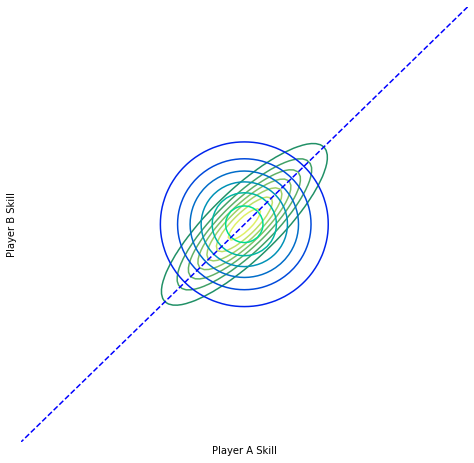

<Figure size 432x288 with 0 Axes>

In [9]:
# Main loop. 
# Reinitialize with the same initialization as you did in 1c) .

#Initialize mean 0, std = 10
init_log_std = torch.tensor([0.,0.],requires_grad=True) # TODO.
init_mean = torch.tensor([0.,0.],requires_grad=True) # TODO.

params = (init_mean, init_log_std)
optimizer = torch.optim.SGD(params, lr=stepsize, momentum=0.9)

print("Optimizing variational parameters...")
for t in trange(0, n_iters):
    update()
    callback(params, t)

print("Final Iteration {} lower bound {}".format(t, objective(params)))

plot_2d_fun(posterior_beat_each_other_10_times, "Player A Skill", "Player B Skill",
            f2=approx_posterior_2d)

Final Loss is: 17.078800201416016.

## 1.2 [34 pts] Approximate inference conditioned on real data 

The dataset contains data on 2546 chess games amongst 1434 players:
 - names is a 1434 by 1 matrix, whose $i$’th entry is the name of player $i$.
 - games is a 2546 by 2 matrix of game outcomes (actually chess matches), one row per game.

The first column contains the indices of the players who won.
The second column contains the indices of the player who lost.

It is based on the kaggle chess dataset: https://www.kaggle.com/datasets/datasnaek/chess




In [10]:
wget.download("https://michalmalyska.github.io/csc412/chess_games.csv")
games = pd.read_csv("chess_games.csv")[["winner_index", "loser_index"]].to_numpy()
wget.download("https://michalmalyska.github.io/csc412/chess_players.csv")
names = pd.read_csv("chess_players.csv")[["index", "player_name"]].to_numpy()

games = torch.LongTensor(games)



**a) [0pt]** Assuming all game outcomes are i.i.d. conditioned on all players' skills, the function $\texttt{log_games_likelihood}$ takes a batch of player skills $\texttt{zs}$ and a collection of observed games $\texttt{games}$ and gives the total log-likelihood for all those observations given all the skills.


In [11]:
def log_games_likelihood(zs, games):
    winning_player_ixs = games[:,0]
    losing_player_ixs = games[:,1]

    winning_player_skills = zs[:, winning_player_ixs] 
    losing_player_skills = zs[:, losing_player_ixs]

    log_likelihoods = logp_a_beats_b(winning_player_skills, losing_player_skills)
    return torch.sum(log_likelihoods, dim=1)

In [12]:
def log_joint_probability(zs):
    return log_joint_prior(zs) + log_games_likelihood(zs, games)

**b) [4pt]** Write a new objective function like the one from the previous question. 

Below, we initialize a variational distribution and fit it to the joint distribution with all the observed tennis games from the dataset.

In [13]:
# Hyperparameters
num_players = 1434
n_iters = 500
stepsize = 0.0001
num_samples_per_iter = 150

def objective(params):
    x = diag_gaussian_samples(params[0], params[1], num_samples_per_iter)
    log_q_phi_z = diag_gaussian_logpdf(x,params[0], params[1])
    L_phi = (1/num_samples_per_iter)*torch.sum((log_joint_probability(x) - log_q_phi_z))
    return -L_phi

**c) [3pts]** Optimize, and report the final loss. 

In [14]:
# Set up optimizer.
init_mean = torch.zeros(num_players, requires_grad=True)
init_log_std  = torch.zeros(num_players, requires_grad=True)
params = (init_mean, init_log_std)
optimizer = torch.optim.SGD(params, lr=stepsize, momentum=0.9)

def update():
    optimizer.zero_grad()
    loss = objective(params)
    loss.backward()
    optimizer.step()

print("Optimizing variational parameters...")
for t in trange(0, n_iters):
    update()
    callback(params, t)

print("Final Iteration {} lower bound {}".format(t, objective(params)))

# Optimize and print loss in a loop
# HINT: you can use the callback() function to report loss


Optimizing variational parameters...


  1%|          | 3/500 [00:00<00:21, 23.20it/s]

Iteration 0 lower bound 2295.94140625


  6%|▌         | 29/500 [00:01<00:23, 20.23it/s]

Iteration 25 lower bound 2196.97412109375


 11%|█         | 53/500 [00:02<00:27, 16.09it/s]

Iteration 50 lower bound 2070.601806640625


 16%|█▌        | 78/500 [00:04<00:24, 17.19it/s]

Iteration 75 lower bound 1980.3758544921875


 21%|██        | 103/500 [00:05<00:27, 14.68it/s]

Iteration 100 lower bound 1917.780517578125


 26%|██▌       | 128/500 [00:08<00:31, 11.86it/s]

Iteration 125 lower bound 1857.5020751953125


 30%|███       | 152/500 [00:10<00:31, 11.06it/s]

Iteration 150 lower bound 1817.7421875


 36%|███▌      | 178/500 [00:11<00:19, 16.17it/s]

Iteration 175 lower bound 1778.378173828125


 41%|████      | 204/500 [00:13<00:19, 14.83it/s]

Iteration 200 lower bound 1750.6278076171875


 46%|████▌     | 229/500 [00:14<00:16, 16.69it/s]

Iteration 225 lower bound 1725.3558349609375


 51%|█████     | 254/500 [00:16<00:16, 15.09it/s]

Iteration 250 lower bound 1703.800048828125


 55%|█████▌    | 277/500 [00:18<00:20, 11.06it/s]

Iteration 275 lower bound 1685.507080078125


 61%|██████    | 303/500 [00:19<00:09, 21.69it/s]

Iteration 300 lower bound 1668.4041748046875


 66%|██████▌   | 330/500 [00:20<00:06, 28.10it/s]

Iteration 325 lower bound 1651.2528076171875


 71%|███████   | 354/500 [00:21<00:05, 29.04it/s]

Iteration 350 lower bound 1641.30419921875


 76%|███████▌  | 381/500 [00:21<00:03, 30.37it/s]

Iteration 375 lower bound 1629.6163330078125


 81%|████████  | 405/500 [00:22<00:03, 30.54it/s]

Iteration 400 lower bound 1621.22412109375


 86%|████████▌ | 429/500 [00:23<00:02, 30.38it/s]

Iteration 425 lower bound 1612.4669189453125


 91%|█████████▏| 457/500 [00:24<00:01, 30.26it/s]

Iteration 450 lower bound 1604.973876953125


 96%|█████████▌| 480/500 [00:25<00:00, 29.39it/s]

Iteration 475 lower bound 1599.4088134765625


100%|██████████| 500/500 [00:25<00:00, 19.33it/s]

Final Iteration 499 lower bound 1592.5120849609375


Final Loss is: 1593.6697998046875.

**d) [1pt]** Plot the approximate mean and variance of all players, sorted by skill.

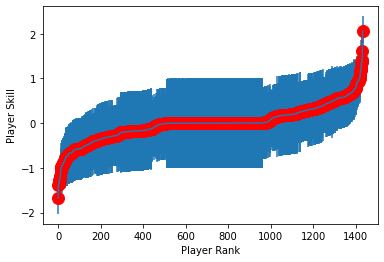

In [15]:
# mean_skills, logstd_skills = # TODO.  Hint: You don't need to do simple Monte Carlo here.
# Hint: You should use .detach() before you do anything with the params tensors
mean_skills, logstd_skills = params[0].detach(), params[1].detach()
order = torch.argsort(mean_skills)

plt.xlabel("Player Rank")
plt.ylabel("Player Skill")

plt.errorbar(range(num_players), mean_skills[order], torch.square(torch.exp(logstd_skills[order])))
plt.plot(range(num_players),mean_skills[order],'ro--', linewidth=2, markersize=12)

**e) [1pts]** List the names of the 10 players with the highest mean skill under the variational model.

In [16]:
best = order[(num_players-10):(num_players)]
best_names = names[best,1]
print(best_names)

['lzchips' 'sneaky_bugger' 'smartduckduckcow' 'hick4u1219' 'cdvh'
 'chesswithmom' 'mrzoom47' 'projetoxadrez' 'laode_syahril' 'doraemon61']


The names of the 10 players with the highest mean skill under the variational model are: 'lzchips', 'sneaky_bugger', 'smartduckduckcow', 'hick4u1219', 'cdvh',
 'chesswithmom', 'mrzoom47', 'projetoxadrez', 'laode_syahril', 'doraemon61'.

**f) [3pt]** Plot samples from the joint posterior over the skills of lelik3310 and thebestofthebad. Based on your samples, describe in a sentence the relationship between the skills of the players. (Is one better than the other? Are they approximately even?)

Answer: Based on the samples from the joint posterior, lelik3310 seems to be better than thebestofthebad.

[496 'lelik3310']
[512 'thebestofthebad']


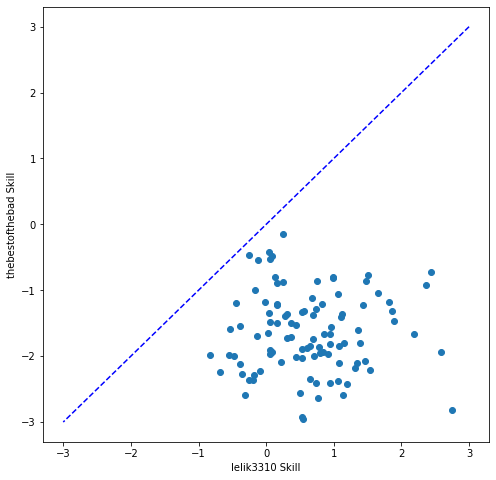

In [17]:
lelik3310_ix = 496
thebestofthebad_ix = 512
print(names[lelik3310_ix])
print(names[thebestofthebad_ix])

fig = plt.figure(figsize=(8,8), facecolor='white')

# Label each with "<player> Skill"
plt.xlabel("lelik3310 Skill") 
plt.ylabel("thebestofthebad Skill") 

plt.plot([3, -3], [3, -3], 'b--') # Line of equal skill

samples = diag_gaussian_samples(mean_skills, logstd_skills, 100)

plt.scatter(samples[:,lelik3310_ix],samples[:,thebestofthebad_ix])
# TODO:  Hint:  Use plt.scatter()

**g) [8pts]** Derive the exact probability under a factorized Gaussian over two players’ skills that one has higher skill than the other, as a function of the two means and variances over their skills. Express your answer in terms of the cumulative distribution function of a one-dimensional Gaussian random variable.

- Hint 1: Use a linear change of variables $y_A, y_B = z_A − z_B , z_B$. What does the line of equal skill look like after this transformation?
- Hint 2: If $X \sim \mathcal N (\mu, \Sigma)$, then $AX \sim \mathcal N (A\mu, A\Sigma A^T)$ where $A$ is a linear transformation.
- Hint 3: Marginalization in Gaussians is easy: if $X \sim \mathcal N (\mu, \Sigma)$, then the $i$th element of $X$ has a
marginal distribution $X_i \sim \mathcal N (\mu_i , \Sigma_{ii})$.

Your answer here:
\
\
First use a linear change of variables $y_A, y_B = z_A − z_B , z_B$. The line of equal skill after this transformation is $y_A = z_A − z_B = 0$. In order to make this linear change of variables we a have a linear transformation matrix $A = \begin{bmatrix} 1 & -1\\0 & 1 \end{bmatrix}$. If the original distribution before the linear transformation is $Z \sim \mathcal N (\mu, \Sigma)$, then $Y = AZ \sim \mathcal N (A\mu, A\Sigma A^T)$ is the new distribution after the transformation. In order to get a one-dimensional distribution of the probability of the difference in skills, we need to marginalize $y_A$ or marginalize out $y_B$. Note that if a distribution $X \sim \mathcal N (\mu, \Sigma)$, then the $i$th element of $X$ has a marginal distribution $X_i \sim \mathcal N (\mu_i , \Sigma_{ii})$. Applying the formula to the new distribution $Y = AZ \sim \mathcal N (A\mu, A\Sigma A^T)$ and getting the marginal of $y_A$, we have the marginal distribution $y_A \sim \mathcal N (\mu_A - \mu_B , \Sigma_{AA} + \Sigma_{BB})$. In order to get the cumulative distribution function (CDF), we can integrate the PDF of the distribution $\mathcal N (\mu_A - \mu_B , \Sigma_{AA} + \Sigma_{BB})$ from $-\infty$ to a skill differential $x$, where $-∞ \le x \le ∞$. Thus, the CDF is $F(x) = \int_{-∞}^{x} f(y) dy$ where $f(y)$ is the PDF of the distribution $\mathcal N (\mu_A - \mu_B , \Sigma_{AA} + \Sigma_{BB})$. The exact probability that player A has higher skill than player B is equal to $F(\infty)-F(0) = 1-F(0)$. Conversely, the exact probability that player B has higher skill than player A is equal to $F(0)$. 

**h) [4pts]** Compute the probability under your approximate posterior that lelik3310 has higher skill than thebestofthebad. Compute this quantity exactly using the formula you just derived above, and also estimate it using simple Monte Carlo with 10000 examples.

Hint:  You might want to use `Normal(0,1).cdf()` for the exact formula.

In [18]:
# TODO
def prob_A_superior_B(N, A_ix, B_ix):
    mu_a = mean_skills[A_ix]
    mu_b = mean_skills[B_ix]
    var_a = torch.square(torch.exp(logstd_skills[A_ix]))
    var_b = torch.square(torch.exp(logstd_skills[B_ix]))
    formula_est = 1 - Normal((mu_a-mu_b),(var_a+var_b)).cdf(torch.tensor([0.]))

    a_samples = torch.normal(mu_a.item(), var_a.item(), size=(N,))
    b_samples = torch.normal(mu_b.item(), var_b.item(), size=(N,))
    gt = torch.gt(a_samples,b_samples)
    mc_est = (1/N)*torch.sum(gt)
    return formula_est.item(), mc_est

formula_est, mc_est = prob_A_superior_B(10000, lelik3310_ix, thebestofthebad_ix)
print(f"Exact CDF Estimate: {formula_est}")
print(f"Simple MC Estimate: {mc_est}")

Exact CDF Estimate: 0.9848490357398987
Simple MC Estimate: 0.998199999332428


**i) [2pts]** Compute the probability that lelik3310 is better than the player with the 5th lowest mean skill. Compute this quantity exactly, and then estimate it using simple Monte Carlo with 10000 examples.


In [19]:
# TODO
fifth_worst_ix = order[4].item()

formula_est, mc_est = prob_A_superior_B(10000, lelik3310_ix, fifth_worst_ix)
print(f"Exact CDF Estimate: {formula_est}")
print(f"Simple MC Estimate: {mc_est}")

Exact CDF Estimate: 0.9525899887084961
Simple MC Estimate: 0.9907999634742737


**j) [4 pts]** Imagine that we knew ahead of time that we were examining the skills of top chess players, and so changed our prior on all players to Normal(10, 1) and re-ran our approximate inference from scratch. Would that change the answer of either of the previous 2 questions, in expectation?

If the prior was changed, then the answers of the two previous questions should be different in expectation since changing the prior should effect the gradient of ELBO. The probability a player being better would be different, but the same player should be better than the other in both cases since changing the prior should only shift the posterior.

**k) [4 pts]** Based on all the plots and results in this assignment and HW2, which approximate inference method do you suspect is producing a better overall approximation to the true posterior over all skills conditioned on all games?  Give a short explanation.

Based on the plots and results of this assignment and HW2, the Hamiltonian Monte Carlo method should produce a better overall approximation to the true posterior over all skills conditioned on all games since the samples seem to fit the true posterior better when plotting the samples against the isocontours and plotting the isocontours of the approximate posterior against the true posterior.

# 2. [21pts] Question 2: VAE Warm up with synthetic data

In this question, we will train a VAE on a synthetic data which resembles spirals in 2d. This question is intended to provided you some debugging tools for the next question where you work on MNIST dataset. In both of the questions, we will perform amortized inference with VAEs.

Function below generates the synthetic spiral data.

In [20]:
# Code to generate the pinwheel dataset.
# Taken from [Johnson et al (2016)], updated by Zhao & Linderman.
def make_pinwheel_data(radial_std, tangential_std, num_classes, num_per_class, rate):
    rads = torch.linspace(0, 2*torch.pi, num_classes + 1)

    features = torch.randn(num_classes*num_per_class, 2) * torch.tensor([radial_std, tangential_std])
    print(features)
    features[:, 0] = features[:, 0] + 1.0
    labels = torch.repeat_interleave(torch.arange(num_classes), num_per_class)

    angles = rads[labels] + rate * torch.exp(features[:,0])
    rotations = torch.stack([np.cos(angles), -np.sin(angles), np.sin(angles), np.cos(angles)])
    rotations = torch.reshape(rotations.T, (-1, 2, 2))

    perm_ix = torch.randperm(labels.shape[0])
    return labels[perm_ix], torch.einsum('ti,tij->tj', features, rotations)[perm_ix]

We visualize the 2d data generated from the above function. Notice that there are 3 clusters in the input space, each colored with a different color. The VAE will not see the cluster assignments, but we hope to recover this structure in the latent space.

tensor([[ 0.3447, -0.1162],
        [ 0.2647,  0.0381],
        [-0.0810, -0.1144],
        ...,
        [-0.2121, -0.0463],
        [-0.2248,  0.0390],
        [-0.1895, -0.1623]])


(-1.8127477169036865,
 1.9069576263427734,
 -1.8728339672088623,
 1.5416526794433594)

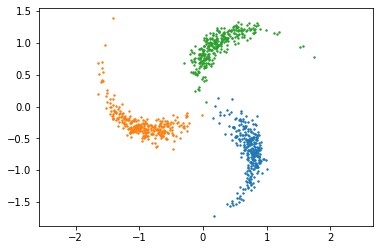

In [21]:
num_clusters = 3           
samples_per_cluster = 300
labels, data = make_pinwheel_data(0.3, 0.1, num_clusters, samples_per_cluster, 0.25)

for k in range(num_clusters):
    plt.scatter(data[labels == k, 0], data[labels == k, 1], s=2)

plt.axis("equal")

## 2.1 [12 pts] Implement the missing lines in the below code, to complete the $\texttt{elbo}$ function for a variational autoencoder.

You can and should use the same code for both the spiral dataset and MNIST.  The spiral dataset and an example encoder / decoder is provided just to help you debug, and as a template for the MNIST VAE.


In [22]:
# Generic VAE functions.

def log_prior(zs_array):
    return diag_gaussian_log_density(zs_array, torch.tensor([0.0]), torch.tensor([1.0]))

def diag_gaussian_samples(mean, log_std, num_samples):
    return mean + torch.exp(log_std) * torch.randn(num_samples, mean.shape[-1])

def diag_gaussian_logpdf(x, mean, log_std):
    return diag_gaussian_log_density(x, mean, torch.exp(log_std))


def batch_elbo(  # Simple Monte Carlo estimate of the variational lower bound.
    recognition_net,    # takes a batch of datapoints, outputs mean and log_std of size (batch_size x latent_dim), i.e. log q(z|x)
    decoder_net,        # takes a batch of latent samples, outputs mean and log_std of size (batch_size x data_dim), i.e. log p(x|z)
    log_joint,          # takes decoder_net, a batch of latent samples, and a batch of datapoints, outputs unnormalized log joint, i.e. log p(x,z)
    data                # a.k.a. x
    ):

    # TODO.  Get posterior parameters
    q_mean, q_log_std = recognition_net.forward(data)
    num_samples = q_mean.size()[0]

    # TODO.  Sample z from approximate posterior.
    q_samples = diag_gaussian_samples(q_mean, q_log_std, num_samples)
    q_log_pdf = diag_gaussian_logpdf(q_samples, q_mean, q_log_std)

    # TODO.  Calculate the joint
    p_log_joint = log_joint(decoder_net,q_samples,data)

    # TODO.  Calculate the log posterior.
    p_log_posterior = p_log_joint - log_prior(data)

    # TODO.  Produce an unbiased esimate of the ELBO.
    L_phi = (1/num_samples)*torch.sum((p_log_posterior - q_log_pdf))

    return L_phi #TODO: return monte carlo estimate

The below code trains a VAE where the encoder and decoder are both neural networks. The parameters are specified in the starter code.  You don't need to do anything here, this is just to help you debug.

In [23]:
from torch.utils.data import TensorDataset, DataLoader
# Now define a specific VAE for the spiral dataset

data_dimension = 2
latent_dimension = 2

# Define the recognition network.
class RecognitionNet(nn.Module):
    def __init__(self, data_dimension, latent_dimension):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(data_dimension, 100),
            nn.ReLU(),
            nn.Linear(100, 50),
            nn.ReLU()
        )
        self.mean_net = nn.Linear(50, latent_dimension) # Output mean of q(z)
        self.std_net = nn.Linear(50, latent_dimension) # Output log_std of q(z)
        
    def forward(self, x):
        interm = self.net(x)
        mean, log_std = self.mean_net(interm), self.std_net(interm)
        return mean, log_std

recognition_net = RecognitionNet(data_dimension, latent_dimension)

# Define the decoder network.
# Note that it has two outputs, a mean and a variance, because 
# this model has a Gaussian likelihood p(x|z).
class Decoder(nn.Module):
    def __init__(self, latent_dimension, data_dimension):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(latent_dimension, 100),
            nn.ReLU(),
            nn.Linear(100, 50),
            nn.ReLU()
        )
        self.mean_net = nn.Linear(50, data_dimension) # Output mean of p(x|z)
        self.std_net = nn.Linear(50, data_dimension) # Output log_std of p(x|z)
        
    def forward(self, x):
        interm = self.net(x)
        mean, log_std = self.mean_net(interm), self.std_net(interm)
        return mean, log_std

decoder_net = Decoder(latent_dimension, data_dimension)

# Set up log likelihood function.
def log_likelihood(decoder_net, latent, data):
    mean, log_std = decoder_net(latent)
    return diag_gaussian_logpdf(data, mean,
                                np.log(0.1) + 0. * log_std)  # Note: we are cheating here and using a fixed noise variance to make optimization more stable.

def log_joint(decoder_net, latent, data):
    return log_prior(latent) + log_likelihood(decoder_net, latent, data)

# Run optimization
optimizer = torch.optim.Adam([{'params': recognition_net.parameters()},
                      {'params': decoder_net.parameters()}], lr=1e-3)
n_iters = 2000
minibatch_size = 300

dataset = TensorDataset(torch.tensor(data))
dataloader = DataLoader(dataset, batch_size=minibatch_size, shuffle=True)

def objective(recognition_net, decoder_net):  # The loss function to be minimized.
    minibatch = next(iter(dataloader))[0]
    return -batch_elbo(
    recognition_net,
    decoder_net,
    log_joint,
    minibatch)

def callback(t):
    if t % 100 == 0:
        print("Iteration {} lower bound {}".format(t, -objective(recognition_net, decoder_net)))

def update():
    optimizer.zero_grad()
    loss = objective(recognition_net, decoder_net)
    loss.backward()
    optimizer.step()

# Main loop.
print("Optimizing variational parameters...")
for t in trange(0, n_iters):
    update()
    callback(t)

print("Iteration {} lower bound {}".format(t, -objective(recognition_net, decoder_net)))

<ipython-input-23-961193f8fe24>:64: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  dataset = TensorDataset(torch.tensor(data))


Optimizing variational parameters...


  1%|          | 11/2000 [00:00<00:18, 104.86it/s]

Iteration 0 lower bound -55.97125244140625


  7%|▋         | 133/2000 [00:00<00:10, 170.46it/s]

Iteration 100 lower bound -1.6249034404754639


 11%|█         | 223/2000 [00:01<00:10, 168.08it/s]

Iteration 200 lower bound 0.16164113581180573


 16%|█▋        | 329/2000 [00:01<00:09, 169.38it/s]

Iteration 300 lower bound 0.5401649475097656


 21%|██        | 418/2000 [00:02<00:09, 167.96it/s]

Iteration 400 lower bound 0.6933119297027588


 26%|██▌       | 513/2000 [00:03<00:09, 156.61it/s]

Iteration 500 lower bound 0.8363560438156128


 31%|███       | 615/2000 [00:03<00:10, 127.03it/s]

Iteration 600 lower bound 0.8705340623855591


 36%|███▌      | 723/2000 [00:04<00:09, 128.35it/s]

Iteration 700 lower bound 0.9750978946685791


 41%|████▏     | 828/2000 [00:05<00:07, 159.82it/s]

Iteration 800 lower bound 1.0868244171142578


 47%|████▋     | 934/2000 [00:06<00:06, 171.73it/s]

Iteration 900 lower bound 1.1956435441970825


 51%|█████▏    | 1026/2000 [00:06<00:05, 177.72it/s]

Iteration 1000 lower bound 1.03790283203125


 57%|█████▋    | 1133/2000 [00:07<00:05, 169.40it/s]

Iteration 1100 lower bound 1.0804660320281982


 61%|██████    | 1219/2000 [00:07<00:04, 166.36it/s]

Iteration 1200 lower bound 1.1224416494369507


 66%|██████▋   | 1326/2000 [00:08<00:03, 173.36it/s]

Iteration 1300 lower bound 1.2274938821792603


 71%|███████   | 1418/2000 [00:08<00:03, 171.74it/s]

Iteration 1400 lower bound 1.1130008697509766


 76%|███████▋  | 1529/2000 [00:09<00:02, 172.22it/s]

Iteration 1500 lower bound 1.1426939964294434


 81%|████████  | 1620/2000 [00:10<00:02, 174.90it/s]

Iteration 1600 lower bound 1.2153395414352417


 87%|████████▋ | 1734/2000 [00:10<00:01, 178.68it/s]

Iteration 1700 lower bound 1.1885666847229004


 91%|█████████ | 1821/2000 [00:11<00:01, 163.23it/s]

Iteration 1800 lower bound 1.1215133666992188


 96%|█████████▋| 1927/2000 [00:11<00:00, 168.85it/s]

Iteration 1900 lower bound 1.2430440187454224


100%|██████████| 2000/2000 [00:12<00:00, 161.84it/s]

Iteration 1999 lower bound 1.2754887342453003


## 2.2 [5 pts]  In this part, we visualize how the data looks like in the latent space. We simply use the trained recognition network (the encoder) to map each input to latent space.


torch.Size([300, 2])
torch.Size([300, 2])
torch.Size([300, 2])


Text(0, 0.5, 'latent dimension 2')

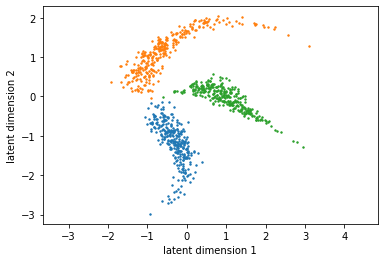

In [24]:
# Show the means of the encoded data in a 2D latent space.
# Don't worry if this doesn't look much like a Gaussian.

for k in range(num_clusters):
    cur_data = data[labels == k] # TODO get all the data from this cluster.
    transformed = recognition_net.forward(cur_data)[0].detach() # TODO find the mean of q(z|x) for each x. Remember to .detach() any tensors

    plt.scatter(transformed[:, 0], transformed[:, 1], s=2)
    print(transformed.shape)

plt.axis("equal")
plt.xlabel("latent dimension 1")
plt.ylabel("latent dimension 2")

## 2.3 [4pts] Generate new data using the decoder and the generative model we just trained.

For this, we simply generate 1000 latent variables in the latent space from the prior and pass it through the decoder network.

You shouldn't expect this to match the data exactly, just to get the overall shape and number of clusters roughly correct.  


(-1.7613000214099883,
 1.828267627954483,
 -1.7051566064357757,
 1.321190756559372)

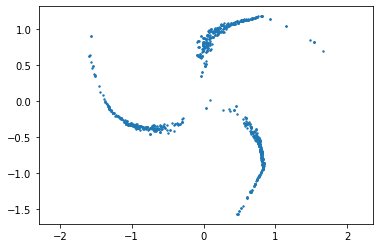

In [25]:
# Sample data from the trained generative model to see if it
# roughly matches the data.  # Note: This doesn't add the likelihood noise,
# although it should if we want it to match the data.

num_samples = 1000
latent_data = recognition_net.forward(data)[0].detach()
n = latent_data.size()[0]
idxs = torch.randint(n,(num_samples,))
samples = latent_data[idxs] # TODO 
transformed = decoder_net.forward(samples)[0].detach() # TODO
plt.scatter(transformed[:, 0], transformed[:, 1], s=2)
plt.axis("equal")

Here's a debugging tool only available when both the latent space and the data are both 2-dimensional.  We can show the function being learned by the encoder by showing how it warps a 2D grid into the latent space.

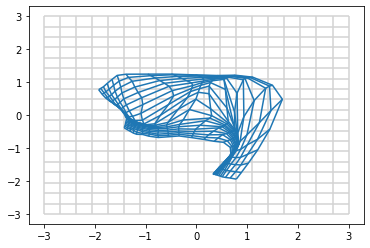

In [26]:
from matplotlib.collections import LineCollection

def plot_grid(x,y, ax=None, **kwargs):
    ax = ax or plt.gca()
    segs1 = np.stack((x,y), axis=2)
    segs2 = segs1.transpose(1,0,2)
    ax.add_collection(LineCollection(segs1, **kwargs))
    ax.add_collection(LineCollection(segs2, **kwargs))
    ax.autoscale()

def f(x,y):
    xy = torch.stack([x.flatten(), y.flatten()], dim=1)
    return decoder_net(xy)

fig, ax = plt.subplots()

grid_x,grid_y = torch.meshgrid(torch.linspace(-3,3,20),torch.linspace(-3,3,20))
plot_grid(grid_x,grid_y, ax=ax,  color="lightgrey")

distx, disty = f(grid_x,grid_y)
distx, disty = distx.reshape(20, 20, 2), disty.reshape(20, 20, 2)
plot_grid(distx[:, :, 0].detach().numpy(), distx[:, :, 1].detach().numpy(), ax=ax, color="C0")

plt.show()

Here, we show the function being learned by the decoder by showing how it warps a 2D grid into the observed space.



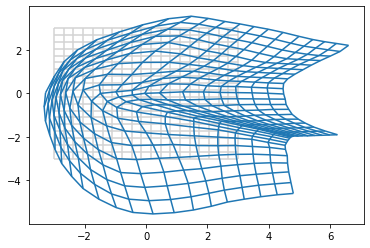

In [27]:
def f(x,y):
    xy = torch.stack([x.flatten(), y.flatten()], dim=1)
    return recognition_net(xy)

fig, ax = plt.subplots()

grid_x,grid_y = torch.meshgrid(torch.linspace(-3,3,20),torch.linspace(-3,3,20))
plot_grid(grid_x,grid_y, ax=ax,  color="lightgrey")

distx, disty = f(grid_x,grid_y)
distx, disty = distx.reshape(20, 20, 2), disty.reshape(20, 20, 2)
plot_grid(distx[:, :, 0].detach().numpy(), distx[:, :, 1].detach().numpy(), ax=ax, color="C0")

plt.show()

#3. [34pts] Question 3: VAE Real Data

In this question, we will implement and investigate the Variational Autoencoder  as introduced by the paper [Auto-Encoding Variational Bayes](https://arxiv.org/pdf/1312.6114.pdf) by Kingma and Welling (2013) on binarized fashion MNIST data.

The below code contains a function that downloads the fashion MNIST data set and another one that can plot multiple images.


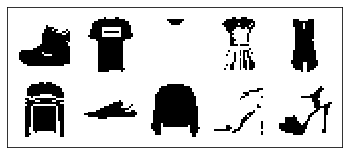

In [28]:
import numpy as np
import os
import gzip
import struct
import array
import matplotlib.pyplot as plt
import matplotlib.image
from urllib.request import urlretrieve

def download(url, filename):
    if not os.path.exists('data'):
        os.makedirs('data')
    out_file = os.path.join('data', filename)
    if not os.path.isfile(out_file):
        urlretrieve(url, out_file)


def fashion_mnist():
    base_url = 'http://fashion-mnist.s3-website.eu-central-1.amazonaws.com/'

    def parse_labels(filename):
        with gzip.open(filename, 'rb') as fh:
            magic, num_data = struct.unpack(">II", fh.read(8))
            return np.array(array.array("B", fh.read()), dtype=np.uint8)

    def parse_images(filename):
        with gzip.open(filename, 'rb') as fh:
            magic, num_data, rows, cols = struct.unpack(">IIII", fh.read(16))
            return np.array(array.array("B", fh.read()), dtype=np.uint8).reshape(num_data, rows, cols)

    for filename in ['train-images-idx3-ubyte.gz',
                     'train-labels-idx1-ubyte.gz',
                     't10k-images-idx3-ubyte.gz',
                     't10k-labels-idx1-ubyte.gz']:
        download(base_url + filename, filename)

    train_images = parse_images('data/train-images-idx3-ubyte.gz')
    train_labels = parse_labels('data/train-labels-idx1-ubyte.gz')
    test_images = parse_images('data/t10k-images-idx3-ubyte.gz')
    test_labels = parse_labels('data/t10k-labels-idx1-ubyte.gz')
    
    # Remove the data point that cause log(0)
    remove = (14926, 20348, 36487, 45128, 50945, 51163, 55023)
    train_images = np.delete(train_images,remove, axis=0)
    train_labels = np.delete(train_labels, remove, axis=0)
    return train_images, train_labels, test_images[:1000], test_labels[:1000]


def load_fashion_mnist():
    partial_flatten = lambda x: np.reshape(x, (x.shape[0], np.prod(x.shape[1:])))
    one_hot = lambda x, k: np.array(x[:, None] == np.arange(k)[None, :], dtype=int)
    train_images, train_labels, test_images, test_labels =  fashion_mnist()
    train_images = (partial_flatten(train_images) / 255.0 > .5).astype(float)
    test_images = (partial_flatten(test_images) / 255.0 > .5).astype(float)
    train_images, test_images = np.float32(train_images), np.float32(test_images)
    train_labels = torch.tensor(one_hot(train_labels, 10))
    test_labels = torch.tensor(one_hot(test_labels, 10))
    N_data = train_images.shape[0]

    return N_data, train_images, train_labels, test_images, test_labels

N_data, train_images, train_labels, test_images, test_labels = load_fashion_mnist()

def plot_images(images, ims_per_row=5, padding=5, dimensions=(28, 28),
                cmap=matplotlib.cm.binary, vmin=0., vmax=1.):
    """Images should be a (N_images x pixels) matrix."""
    fig = plt.figure(1)
    fig.clf()
    ax = fig.add_subplot(111)

    N_images = images.shape[0]
    N_rows = np.int32(np.ceil(float(N_images) / ims_per_row))
    pad_value = vmin
    concat_images = np.full(((dimensions[0] + padding) * N_rows + padding,
                             (dimensions[1] + padding) * ims_per_row + padding), pad_value)
    for i in range(N_images):
        cur_image = np.reshape(images[i, :], dimensions)
        row_ix = i // ims_per_row
        col_ix = i % ims_per_row
        row_start = padding + (padding + dimensions[0]) * row_ix
        col_start = padding + (padding + dimensions[1]) * col_ix
        concat_images[row_start: row_start + dimensions[0],
                      col_start: col_start + dimensions[1]] = cur_image
        cax = ax.matshow(concat_images, cmap=cmap, vmin=vmin, vmax=vmax)
        plt.xticks(np.array([]))
        plt.yticks(np.array([]))
    
    plt.plot()

plot_images(train_images[:10, :])

## 3.1 [15 pts] Implement the missing lines in the below code, and report the final ELBO

### The model is as follows:

*   **Prior:** The prior over each items's latent representation is a multivariate standard normal distribution. For all questions, we'll set the dimension of the latent space to 2.
A larger latent dimension would provide a more powerful model, but for this assignment we'll use a two-dimensional latent space to make visualization and debugging easier.


*   **Likelihood:** Given the latent representation $z$ for an image, the distribution over all 784 pixels in the image is given by a product of independent Bernoullis, whose means are given by the output of a neural network $f_\theta(z)$:
$$p(x|z, \theta) = \prod_{d=1}^{784} \operatorname{Ber}(x_d|f_\theta(z)_d)$$
The neural network $f_\theta$ is called the decoder, and its parameters $\theta$ will be optimized to fit the data.

### the functions to complete:
1.   $\texttt{log_likelihood}$: Log-likelihood of the above model.
2.   $\texttt{log_joint}$: Joint log-likelihood of data and latent variables.
3.   $\texttt{objective}$: You will use the elbo function you wrote in the previous question.

### Report the final ELBO. 

In [29]:
 
 # Define a specific VAE for MNIST

data_dimension = 28*28
latent_dimension = 2

# Define the recognition network.
class RecognitionNet(nn.Module):
    def __init__(self, data_dimension, latent_dimension):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(data_dimension, 150),
            nn.ReLU(),
            nn.Linear(150, 50),
            nn.ReLU()
        )
        self.mean_net = nn.Linear(50, latent_dimension) # Output mean of q(z)
        self.std_net = nn.Linear(50, latent_dimension) # Output log_std of q(z)
        
    def forward(self, x):
        interm = self.net(x)
        mean, log_std = self.mean_net(interm), self.std_net(interm)
        return mean, log_std

recognition_net = RecognitionNet(data_dimension, latent_dimension) # TODO: What are the input and output dimensions of the encoder?

# Define the decoder network.
class Decoder(nn.Module):
    def __init__(self, latent_dimension, data_dimension):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(latent_dimension, 150),
            nn.ReLU(),
            nn.Linear(150, 50),
            nn.ReLU(),
            nn.Linear(50, data_dimension) # TODO: Output logit of Ber(x|z)
        )
        
    def forward(self, x):
        return self.net(x)

decoder_net = Decoder(latent_dimension,data_dimension) # TODO: What are the input and output dimensions of the decoder?

# Set up log likelihood function.
def bernoulli_logpdf(logits, x):
    """Bernoulli log pdf of data x given logits."""
    return -torch.sum(torch.logaddexp(torch.tensor([0.]), torch.where(x > 0.5, -1., 1.) * logits), dim=1)

def log_likelihood(decoder_net, latent, data): # TODO
    return bernoulli_logpdf(decoder_net.forward(latent),data)

def log_joint(decoder_net, latent, data): # TODO
    # Assume prior with mu = 0, std = 1
    return log_likelihood(decoder_net, latent, data) + diag_gaussian_log_density(latent, torch.tensor([0]), torch.tensor([1.0]))

# Run optimization
optimizer = torch.optim.Adam([{'params': recognition_net.parameters()},
                      {'params': decoder_net.parameters()}], lr=1e-2)
n_iters = 5000
minibatch_size = 200

dataset = TensorDataset(torch.tensor(train_images), )
dataloader = DataLoader(dataset, batch_size=minibatch_size, shuffle=True)

def objective(recognition_net, decoder_net):  # The loss function to be minimized.  
    minibatch = next(iter(dataloader))[0] # TODO
    return -batch_elbo(recognition_net,decoder_net,log_joint,minibatch) # TODO

def callback(t):
    if t % 100 == 0:
        print("Iteration {} lower bound {}".format(t, -objective(recognition_net, decoder_net)))

def update():
    optimizer.zero_grad()
    loss = objective(recognition_net, decoder_net)
    loss.backward()
    optimizer.step()

# Main loop.
print("Optimizing variational parameters...")
for t in trange(0, n_iters):
    update()
    callback(t)

callback(n_iters)

Optimizing variational parameters...


  0%|          | 6/5000 [00:00<01:33, 53.30it/s]

Iteration 0 lower bound 315.3464660644531


  2%|▏         | 108/5000 [00:01<01:32, 53.15it/s]

Iteration 100 lower bound 636.6040649414062


  4%|▍         | 210/5000 [00:03<01:28, 54.30it/s]

Iteration 200 lower bound 636.4798583984375


  6%|▌         | 312/5000 [00:05<01:25, 54.81it/s]

Iteration 300 lower bound 634.37646484375


  8%|▊         | 408/5000 [00:07<01:24, 54.02it/s]

Iteration 400 lower bound 650.4700317382812


 10%|█         | 506/5000 [00:09<02:06, 35.45it/s]

Iteration 500 lower bound 642.0101928710938


 12%|█▏        | 611/5000 [00:11<01:19, 55.45it/s]

Iteration 600 lower bound 661.2926635742188


 14%|█▍        | 707/5000 [00:13<01:18, 54.60it/s]

Iteration 700 lower bound 653.1978759765625


 16%|█▌        | 809/5000 [00:15<01:17, 53.79it/s]

Iteration 800 lower bound 667.6351318359375


 18%|█▊        | 911/5000 [00:17<01:15, 53.83it/s]

Iteration 900 lower bound 669.1569213867188


 20%|██        | 1007/5000 [00:18<01:11, 55.53it/s]

Iteration 1000 lower bound 663.0308227539062


 22%|██▏       | 1106/5000 [00:21<01:45, 36.82it/s]

Iteration 1100 lower bound 664.1690673828125


 24%|██▍       | 1210/5000 [00:23<01:10, 53.43it/s]

Iteration 1200 lower bound 659.3327026367188


 26%|██▌       | 1312/5000 [00:25<01:07, 54.42it/s]

Iteration 1300 lower bound 665.3487548828125


 28%|██▊       | 1408/5000 [00:26<01:03, 56.28it/s]

Iteration 1400 lower bound 675.7933959960938


 30%|███       | 1512/5000 [00:28<01:02, 55.98it/s]

Iteration 1500 lower bound 669.7740478515625


 32%|███▏      | 1608/5000 [00:30<01:02, 54.11it/s]

Iteration 1600 lower bound 656.84912109375


 34%|███▍      | 1704/5000 [00:32<01:08, 47.98it/s]

Iteration 1700 lower bound 652.4150390625


 36%|███▌      | 1810/5000 [00:34<00:59, 53.65it/s]

Iteration 1800 lower bound 653.465087890625


 38%|███▊      | 1912/5000 [00:36<00:55, 55.37it/s]

Iteration 1900 lower bound 647.9112548828125


 40%|████      | 2009/5000 [00:38<00:53, 56.02it/s]

Iteration 2000 lower bound 666.40771484375


 42%|████▏     | 2111/5000 [00:40<00:52, 54.75it/s]

Iteration 2100 lower bound 668.8798828125


 44%|████▍     | 2207/5000 [00:41<00:50, 55.71it/s]

Iteration 2200 lower bound 676.5423583984375


 46%|████▌     | 2309/5000 [00:43<00:50, 53.35it/s]

Iteration 2300 lower bound 671.267333984375


 48%|████▊     | 2408/5000 [00:46<01:07, 38.63it/s]

Iteration 2400 lower bound 675.2978515625


 50%|█████     | 2510/5000 [00:47<00:45, 54.99it/s]

Iteration 2500 lower bound 664.7899169921875


 52%|█████▏    | 2606/5000 [00:49<00:43, 55.61it/s]

Iteration 2600 lower bound 673.1697998046875


 54%|█████▍    | 2708/5000 [00:51<00:43, 53.20it/s]

Iteration 2700 lower bound 668.2683715820312


 56%|█████▌    | 2810/5000 [00:53<00:39, 55.36it/s]

Iteration 2800 lower bound 654.7308959960938


 58%|█████▊    | 2912/5000 [00:55<00:37, 55.47it/s]

Iteration 2900 lower bound 671.3663330078125


 60%|██████    | 3006/5000 [00:57<00:55, 35.71it/s]

Iteration 3000 lower bound 667.952880859375


 62%|██████▏   | 3109/5000 [00:59<00:34, 55.51it/s]

Iteration 3100 lower bound 668.435546875


 64%|██████▍   | 3211/5000 [01:01<00:32, 55.34it/s]

Iteration 3200 lower bound 670.0958251953125


 66%|██████▌   | 3312/5000 [01:03<00:42, 39.36it/s]

Iteration 3300 lower bound 672.4800415039062


 68%|██████▊   | 3410/5000 [01:05<00:31, 49.92it/s]

Iteration 3400 lower bound 663.1678466796875


 70%|███████   | 3512/5000 [01:07<00:27, 54.21it/s]

Iteration 3500 lower bound 679.9839477539062


 72%|███████▏  | 3609/5000 [01:10<00:34, 40.74it/s]

Iteration 3600 lower bound 659.0604248046875


 74%|███████▍  | 3711/5000 [01:11<00:22, 56.47it/s]

Iteration 3700 lower bound 659.9171752929688


 76%|███████▌  | 3807/5000 [01:13<00:21, 55.11it/s]

Iteration 3800 lower bound 656.91748046875


 78%|███████▊  | 3909/5000 [01:15<00:20, 54.16it/s]

Iteration 3900 lower bound 674.2068481445312


 80%|████████  | 4011/5000 [01:17<00:18, 54.35it/s]

Iteration 4000 lower bound 662.1458740234375


 82%|████████▏ | 4107/5000 [01:19<00:16, 54.46it/s]

Iteration 4100 lower bound 659.3396606445312


 84%|████████▍ | 4207/5000 [01:21<00:22, 35.38it/s]

Iteration 4200 lower bound 681.283203125


 86%|████████▌ | 4310/5000 [01:23<00:13, 52.57it/s]

Iteration 4300 lower bound 656.1900634765625


 88%|████████▊ | 4412/5000 [01:25<00:10, 54.47it/s]

Iteration 4400 lower bound 668.795166015625


 90%|█████████ | 4508/5000 [01:27<00:09, 54.60it/s]

Iteration 4500 lower bound 675.6395263671875


 92%|█████████▏| 4610/5000 [01:28<00:06, 56.41it/s]

Iteration 4600 lower bound 659.6476440429688


 94%|█████████▍| 4712/5000 [01:30<00:05, 55.37it/s]

Iteration 4700 lower bound 671.4835815429688


 96%|█████████▌| 4806/5000 [01:32<00:04, 38.99it/s]

Iteration 4800 lower bound 663.0302734375


 98%|█████████▊| 4908/5000 [01:34<00:01, 54.48it/s]

Iteration 4900 lower bound 672.5938110351562


100%|██████████| 5000/5000 [01:36<00:00, 51.81it/s]

Iteration 5000 lower bound 675.4716796875


The Final ELBO is 682.4476928710938.

## 3.2 [3pts]
 
In what follows, we will investigate our model by visualizing the distribution over data given by the generative model, sampling from it, and interpolating between items.

One way to understand the meaning of latent representations is to see which parts of the latent space correspond to which kinds of data. Here we'll produce a scatter plot in the latent space, where each point in the plot represents a different image in the training set.

Implement the missing lines in the below code, to plot the transformed data points in the latent space.



1.   Encode each image in the training set.
2.   Take the 2D mean vector of each encoding $q_\phi(z|x)$.
3.   Plot these mean vectors in the 2D latent space with a scatterplot.
4.   Colour each point according to the class label (0 to 9).


Hopefully our latent space will group images of different classes, even though we never provided class labels to the model!





(-2.6775394082069397, 3.05061274766922, -3.609655833244324, 2.8279666662216187)

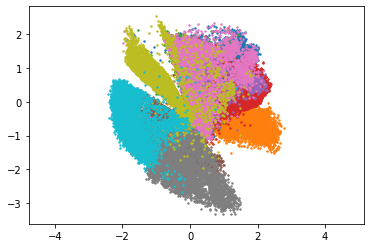

In [30]:
for k in range(10):
    cur_data = torch.tensor(train_images[train_labels[:, k] == True, :]).to(torch.float32)
    transformed = recognition_net.forward(cur_data)[0].detach() # TODO:  Call recognition net and extract mean, remember to .detach() the tensors!
    plt.scatter(transformed[:, 0], transformed[:, 1], s=2)

plt.axis("equal")

## 3.3 [8 pts] 
Now we'll fit a model with a larger latent space.  We won't be able to visualize this model as easily, but it should be able to fit the data better.  Set latent_dimension to 20 and re-fit the model.  You should be able to get a better ELBO using this larger model.

In [31]:
# TODO: Train the same model as above but with latent_dimension = 20
# Feel free to copy code from above.

 # Define a specific VAE for MNIST

data_dimension = 28*28
latent_dimension = 20

# Define the recognition network.
class RecognitionNet(nn.Module):
    def __init__(self, data_dimension, latent_dimension):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(data_dimension, 150),
            nn.ReLU(),
            nn.Linear(150, 50),
            nn.ReLU()
        )
        self.mean_net = nn.Linear(50, latent_dimension) # Output mean of q(z)
        self.std_net = nn.Linear(50, latent_dimension) # Output log_std of q(z)
        
    def forward(self, x):
        interm = self.net(x)
        mean, log_std = self.mean_net(interm), self.std_net(interm)
        return mean, log_std

recognition_net = RecognitionNet(data_dimension, latent_dimension) # TODO: What are the input and output dimensions of the encoder?

# Define the decoder network.
class Decoder(nn.Module):
    def __init__(self, latent_dimension, data_dimension):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(latent_dimension, 150),
            nn.ReLU(),
            nn.Linear(150, 50),
            nn.ReLU(),
            nn.Linear(50, data_dimension) # TODO: Output logit of Ber(x|z)
        )
        
    def forward(self, x):
        return self.net(x)

decoder_net = Decoder(latent_dimension,data_dimension) # TODO: What are the input and output dimensions of the decoder?

# Set up log likelihood function.
def bernoulli_logpdf(logits, x):
    """Bernoulli log pdf of data x given logits."""
    return -torch.sum(torch.logaddexp(torch.tensor([0.]), torch.where(x > 0.5, -1., 1.) * logits), dim=1)

def log_likelihood(decoder_net, latent, data): # TODO
    return bernoulli_logpdf(decoder_net.forward(latent),data)

def log_joint(decoder_net, latent, data): # TODO
    # Assume prior with mu = 0, std = 1
    return log_likelihood(decoder_net, latent, data) + diag_gaussian_log_density(latent, torch.tensor([0]), torch.tensor([1.0]))

# Run optimization
optimizer = torch.optim.Adam([{'params': recognition_net.parameters()},
                      {'params': decoder_net.parameters()}], lr=1e-2)
n_iters = 5000
minibatch_size = 200

dataset = TensorDataset(torch.tensor(train_images), )
dataloader = DataLoader(dataset, batch_size=minibatch_size, shuffle=True)

def objective(recognition_net, decoder_net):  # The loss function to be minimized.  
    minibatch = next(iter(dataloader))[0] # TODO
    return -batch_elbo(recognition_net,decoder_net,log_joint,minibatch) # TODO

def callback(t):
    if t % 100 == 0:
        print("Iteration {} lower bound {}".format(t, -objective(recognition_net, decoder_net)))

def update():
    optimizer.zero_grad()
    loss = objective(recognition_net, decoder_net)
    loss.backward()
    optimizer.step()

# Main loop.
print("Optimizing variational parameters...")
for t in trange(0, n_iters):
    update()
    callback(t)

callback(n_iters)

Optimizing variational parameters...


  0%|          | 5/5000 [00:00<01:53, 44.08it/s]

Iteration 0 lower bound 300.33367919921875


  2%|▏         | 107/5000 [00:02<01:30, 53.98it/s]

Iteration 100 lower bound 613.8106689453125


  4%|▍         | 209/5000 [00:03<01:27, 54.59it/s]

Iteration 200 lower bound 648.5488891601562


  6%|▌         | 305/5000 [00:05<01:44, 44.80it/s]

Iteration 300 lower bound 668.0812377929688


  8%|▊         | 411/5000 [00:08<01:27, 52.52it/s]

Iteration 400 lower bound 676.4542236328125


 10%|█         | 507/5000 [00:10<01:22, 54.25it/s]

Iteration 500 lower bound 685.716796875


 12%|█▏        | 609/5000 [00:11<01:23, 52.82it/s]

Iteration 600 lower bound 672.7391967773438


 14%|█▍        | 711/5000 [00:13<01:19, 53.75it/s]

Iteration 700 lower bound 694.341064453125


 16%|█▌        | 807/5000 [00:15<01:18, 53.19it/s]

Iteration 800 lower bound 686.1427001953125


 18%|█▊        | 909/5000 [00:17<01:20, 50.96it/s]

Iteration 900 lower bound 680.9048461914062


 20%|██        | 1007/5000 [00:19<01:20, 49.71it/s]

Iteration 1000 lower bound 687.1532592773438


 22%|██▏       | 1109/5000 [00:21<01:13, 52.68it/s]

Iteration 1100 lower bound 697.8985595703125


 24%|██▍       | 1211/5000 [00:23<01:12, 52.52it/s]

Iteration 1200 lower bound 687.6749877929688


 26%|██▌       | 1307/5000 [00:25<01:09, 53.46it/s]

Iteration 1300 lower bound 682.7954711914062


 28%|██▊       | 1409/5000 [00:27<01:05, 54.75it/s]

Iteration 1400 lower bound 676.8696899414062


 30%|███       | 1511/5000 [00:29<01:04, 53.69it/s]

Iteration 1500 lower bound 680.2976684570312


 32%|███▏      | 1608/5000 [00:31<01:11, 47.29it/s]

Iteration 1600 lower bound 697.3734130859375


 34%|███▍      | 1710/5000 [00:33<01:01, 53.65it/s]

Iteration 1700 lower bound 682.1878662109375


 36%|███▌      | 1812/5000 [00:35<00:59, 53.65it/s]

Iteration 1800 lower bound 696.3912353515625


 38%|███▊      | 1908/5000 [00:37<00:57, 53.41it/s]

Iteration 1900 lower bound 697.1300048828125


 40%|████      | 2010/5000 [00:39<00:56, 53.25it/s]

Iteration 2000 lower bound 683.8656005859375


 42%|████▏     | 2106/5000 [00:40<00:55, 52.08it/s]

Iteration 2100 lower bound 692.9271850585938


 44%|████▍     | 2209/5000 [00:43<01:06, 41.79it/s]

Iteration 2200 lower bound 692.2838134765625


 46%|████▌     | 2311/5000 [00:45<00:51, 52.37it/s]

Iteration 2300 lower bound 686.2347412109375


 48%|████▊     | 2407/5000 [00:47<00:49, 52.81it/s]

Iteration 2400 lower bound 694.3455200195312


 50%|█████     | 2509/5000 [00:49<00:46, 53.09it/s]

Iteration 2500 lower bound 701.4713745117188


 52%|█████▏    | 2611/5000 [00:51<00:44, 53.12it/s]

Iteration 2600 lower bound 691.0003051757812


 54%|█████▍    | 2707/5000 [00:52<00:42, 53.45it/s]

Iteration 2700 lower bound 684.8129272460938


 56%|█████▌    | 2805/5000 [00:55<01:03, 34.34it/s]

Iteration 2800 lower bound 702.4716186523438


 58%|█████▊    | 2910/5000 [00:57<00:40, 51.76it/s]

Iteration 2900 lower bound 695.9671020507812


 60%|██████    | 3006/5000 [00:58<00:37, 53.79it/s]

Iteration 3000 lower bound 700.9447631835938


 62%|██████▏   | 3108/5000 [01:00<00:35, 52.98it/s]

Iteration 3100 lower bound 691.3063354492188


 64%|██████▍   | 3210/5000 [01:02<00:33, 53.01it/s]

Iteration 3200 lower bound 692.376708984375


 66%|██████▌   | 3306/5000 [01:04<00:32, 52.08it/s]

Iteration 3300 lower bound 692.2493896484375


 68%|██████▊   | 3405/5000 [01:06<00:46, 34.66it/s]

Iteration 3400 lower bound 696.357177734375


 70%|███████   | 3511/5000 [01:09<00:27, 53.91it/s]

Iteration 3500 lower bound 687.3619995117188


 72%|███████▏  | 3607/5000 [01:10<00:26, 52.81it/s]

Iteration 3600 lower bound 699.331787109375


 74%|███████▍  | 3709/5000 [01:12<00:24, 52.74it/s]

Iteration 3700 lower bound 691.7162475585938


 76%|███████▌  | 3811/5000 [01:14<00:22, 53.33it/s]

Iteration 3800 lower bound 697.2622680664062


 78%|███████▊  | 3907/5000 [01:16<00:20, 53.83it/s]

Iteration 3900 lower bound 697.365234375


 80%|████████  | 4006/5000 [01:18<00:28, 34.29it/s]

Iteration 4000 lower bound 687.6881713867188


 82%|████████▏ | 4107/5000 [01:20<00:16, 52.77it/s]

Iteration 4100 lower bound 687.431640625


 84%|████████▍ | 4209/5000 [01:22<00:15, 52.27it/s]

Iteration 4200 lower bound 695.3569946289062


 86%|████████▌ | 4311/5000 [01:24<00:13, 52.48it/s]

Iteration 4300 lower bound 692.7908935546875


 88%|████████▊ | 4407/5000 [01:26<00:11, 53.74it/s]

Iteration 4400 lower bound 690.6396484375


 90%|█████████ | 4509/5000 [01:28<00:09, 54.17it/s]

Iteration 4500 lower bound 697.1505126953125


 92%|█████████▏| 4608/5000 [01:30<00:10, 37.04it/s]

Iteration 4600 lower bound 695.888916015625


 94%|█████████▍| 4710/5000 [01:32<00:05, 53.10it/s]

Iteration 4700 lower bound 693.9888916015625


 96%|█████████▌| 4812/5000 [01:34<00:03, 54.64it/s]

Iteration 4800 lower bound 691.0209350585938


 98%|█████████▊| 4908/5000 [01:36<00:01, 53.20it/s]

Iteration 4900 lower bound 692.1920776367188


100%|██████████| 5000/5000 [01:37<00:00, 51.05it/s]

Iteration 5000 lower bound 698.1571655273438


ELBO is better reaching a final ELBO of 690.8218383789062 and reaching an ELBO of 707.15625 at one point.

## 3.4) [4pts] Implement the missing lines in the below code, to plot the transformed data points in the latent space.

You will be using ancestral sampling:	

1.   First sample a z from the prior.
2.   Use the generative model to compute the bernoulli means over the pixels of $x$ given $z$. 
3.   Plot these means (parameters) as a greyscale image.

Do this for 25 samples z from the prior.

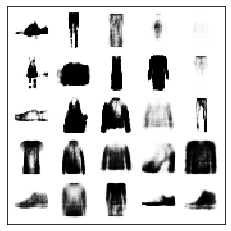

In [37]:
# Sample data from the trained generative model to see if it
# roughly matches the data.

def sigmoid(x):
  # Maps logits to probabilities.
  return 0.5 * (torch.tanh(x) + 1.0)

# Assume want to transform data from latent space to data dimension
sampled_zs = torch.randn(25,latent_dimension) # TODO: Sample from prior on z.
bernoulli_means = sigmoid(decoder_net.forward(sampled_zs).detach()) # TODO: Get logits, and map them to probabilities. Don't forget to .detach()
plot_images(bernoulli_means)

## 3.5 [4pts]

Another way to examine a latent variable model with continuous latent variables is to interpolate between the latent representations of two points. Here we will encode 3 pairs of data points with different classes. Then we will linearly interpolate between the mean vectors of their encodings. We will plot the generative distributions along the linear interpolation.


1.   First, write a function which takes two points $z_a$ and $z_b$, and a value $\alpha \in [0,1]$, and outputs the linear interpolation $z_\alpha = \alpha z_a + (1-\alpha)z_b$.
2.  Sample 3 pairs of images, each having a different class.
3.  Encode the data in each pair, and take the mean vectors
4.  Linearly interpolate between these mean vectors
5.  At 10 equally-space points along the interpolation, plot the Bernoulli means $p(x|z_\alpha)$.
6.  Concatenate these plots into one figure.

In [58]:
def plot_interp(ix1, ix2):
    left_z = recognition_net(torch.tensor(train_images[ix1, :]).to(torch.float32))[0].detach()
    right_z = recognition_net(torch.tensor(train_images[ix2, :]).to(torch.float32))[0].detach()
    interp_weights = list(torch.linspace(0.0, 1.0, 10))
    all_means = torch.zeros(10,data_dimension)
    for i in range(10):
        alpha = interp_weights[i]
        interp_zs = torch.unsqueeze(alpha*left_z+(1-alpha)*right_z,0) # TODO: Linearly interpolate between left_z and right_z.  Feel free to use a for loop. You don't have to use interp_weights, but they might be helpful
        bernoulli_means = sigmoid(decoder_net.forward(interp_zs).detach()) # TODO:
        all_means[i,:] = bernoulli_means
    plot_images(all_means)


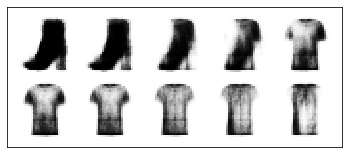

In [59]:
plot_interp(3, 11)

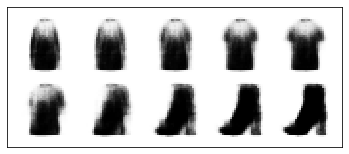

In [60]:
plot_interp(11, 22)

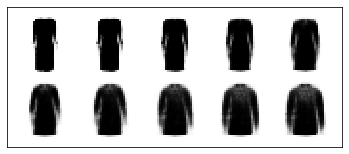

In [61]:
plot_interp(32, 334)